# Weather Data Processing Pipeline

## Overview
This project involves collecting, cleaning, and processing historical weather data from a blog. The primary steps in the pipeline are:
1. **Data Scraping:** Collecting raw weather data from a blog for multiple years and months.
2. **Data Consolidation:** Combining monthly data into yearly summaries.
3. **Data Cleaning:** Removing unnecessary elements (e.g., HTML tags) to normalize the data.
4. **Data Parsing:** Extracting structured information such as temperature, precipitation, and weather descriptions.

This notebook documents the workflow step by step, with detailed explanations and code snippets for each stage.

---

## Step 1: Data Scraping
The first step involves collecting weather data from the blog. The data is scraped for each month of a specified year range and saved as JSON files. This ensures we have a local copy of the data for further processing.

### Objective
- Extract raw weather data from the blog.
- Save the data as JSON files organized by month.

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import json

# Base URL for the weather blog
base_url = "https://lunzerwetter.blogspot.com"

# Range of years and months
years = range(2014, 2025)
months = [f"{month:02}" for month in range(1, 13)]

# Create a directory to save scraped data
output_folder = "monthly_weather_data"
os.makedirs(output_folder, exist_ok=True)

def scrape_month_page(url):
    """
    Scrapes weather data for a given month URL.

    Args:
        url (str): URL of the monthly weather page.
    
    Returns:
        list: A list of HTML strings containing weather entries.
    """
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to load {url}, status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")
    entries = soup.find_all("div", class_="post-body entry-content")
    return [entry.decode_contents() for entry in entries]

# Scrape weather data for the specified range of years and months
for year in years:
    for month in months:
        monthly_url = f"{base_url}/{year}/{month}/"
        print(f"Scraping {monthly_url}...")

        monthly_entries = scrape_month_page(monthly_url)

        if monthly_entries:
            file_name = f"{year}_{month}.json"
            file_path = os.path.join(output_folder, file_name)

            with open(file_path, "w", encoding="utf-8") as file:
                json.dump(monthly_entries, file, ensure_ascii=False, indent=4)

            print(f"Saved {len(monthly_entries)} entries to {file_name}.")
        else:
            print(f"No entries found for {monthly_url}.")

print(f"Data saved in '{output_folder}' folder.")


Scraping https://lunzerwetter.blogspot.com/2014/01/...
Saved 31 entries to 2014_01.json.
Scraping https://lunzerwetter.blogspot.com/2014/02/...
Saved 29 entries to 2014_02.json.
Scraping https://lunzerwetter.blogspot.com/2014/03/...
Saved 31 entries to 2014_03.json.
Scraping https://lunzerwetter.blogspot.com/2014/04/...
Saved 31 entries to 2014_04.json.
Scraping https://lunzerwetter.blogspot.com/2014/05/...
Saved 33 entries to 2014_05.json.
Scraping https://lunzerwetter.blogspot.com/2014/06/...
Saved 29 entries to 2014_06.json.
Scraping https://lunzerwetter.blogspot.com/2014/07/...
Saved 31 entries to 2014_07.json.
Scraping https://lunzerwetter.blogspot.com/2014/08/...
Saved 31 entries to 2014_08.json.
Scraping https://lunzerwetter.blogspot.com/2014/09/...
Saved 30 entries to 2014_09.json.
Scraping https://lunzerwetter.blogspot.com/2014/10/...
Saved 31 entries to 2014_10.json.
Scraping https://lunzerwetter.blogspot.com/2014/11/...
Saved 30 entries to 2014_11.json.
Scraping https://lunz

## Step 2: Data Consolidation
### Overview
The goal of this step is to consolidate the monthly weather data into yearly files. Each yearly file contains only relevant entries that include specific markers indicating historical weather data.

---

### Create Folders for Input and Output
The input folder contains the scraped monthly data, while the output folder will store the consolidated yearly data.


In [5]:
# Define input and output directories
input_folder = "monthly_weather_data"
output_folder = "yearly_weather_data"
os.makedirs(output_folder, exist_ok=True)

### Extract Relevant Data
A helper function is defined to extract weather entries that include a specific marker, "Das Wetter vor 50 Jahren:". This ensures that only entries with historical weather data are retained.

In [12]:
def extract_weather_50_years(entry):
    """
    Extracts the portion of the entry that contains historical weather data.

    Args:
        entry (str): The raw weather entry.
    
    Returns:
        str or None: The extracted data after the marker or None if the marker is not found.
    """
    marker = 'Das Wetter vor 50 Jahren:'
    if marker in entry:
        return entry.split(marker, 1)[1].strip()
    return None

### Consolidate Data for Each Year
The script processes data for each year. For every month:
1. It reads the corresponding JSON file, if available.
2. Extracts relevant entries using the `extract_weather_50_years` function.
3. Appends the extracted data to a yearly collection.

In [15]:
for year in range(2014, 2025):
    yearly_data = []  # Consolidated data for the year

    for month in range(1, 13):
        file_name = f"{year}_{month:02}.json"
        file_path = os.path.join(input_folder, file_name)

        # Check if the file exists
        if os.path.exists(file_path):
            with open(file_path, "r", encoding="utf-8") as file:
                monthly_entries = json.load(file)

                # Extract relevant parts for each entry
                for entry in monthly_entries:
                    extracted = extract_weather_50_years(entry)
                    if extracted:
                        yearly_data.append(extracted)

### Save Consolidated Data
If relevant data is found for a year, it is saved into a new JSON file in the output folder. A message is logged indicating the success or failure of the operation.

In [18]:
    # Save the consolidated yearly data to a new JSON file
    if yearly_data:
        output_file = os.path.join(output_folder, f"{year}.json")
        with open(output_file, "w", encoding="utf-8") as file:
            json.dump(yearly_data, file, ensure_ascii=False, indent=4)
        print(f"Saved {len(yearly_data)} entries to {output_file}.")
    else:
        print(f"No valid data found for {year}.")

print("Consolidation completed.")

Saved 359 entries to yearly_weather_data/2024.json.
Consolidation completed.


## Step 3: Data Cleaning
### Overview
In this step, we clean the consolidated yearly weather data to remove unnecessary HTML tags, normalize spaces, and reformat the text for further processing.

---

### Set Up Input and Output Folders
The input folder contains the consolidated yearly data, while the cleaned data is saved in a new output folder.

In [21]:
import re
import os
import json

# Define input and output directories
input_folder = "yearly_weather_data"
output_folder = "cleaned_weather_data"
os.makedirs(output_folder, exist_ok=True)

### Cleaning Function
The `clean_entry` function performs the following operations:
1. Removes HTML tags.
2. Normalizes multiple spaces to a single space.
3. Strips leading and trailing spaces.
4. Replaces spaces with semicolons to standardize delimiters.

In [27]:
def clean_entry(entry):
    """
    Cleans a single weather data entry by removing HTML tags,
    normalizing spaces, and standardizing delimiters.
    
    Args:
        entry (str): The raw weather data entry.
    
    Returns:
        str: The cleaned and normalized entry.
    """
    entry = re.sub(r"<.*?>", "", entry)  # Remove HTML tags
    entry = re.sub(r"\s{2,}", " ", entry)  # Replace multiple spaces with a single space
    entry = entry.strip()  # Trim leading and trailing spaces
    entry = entry.replace(" ", ";")  # Replace spaces with semicolons
    return entry

### Process Each Year’s Data
The script iterates through the yearly data files, applies the cleaning function to each entry, and saves the cleaned data to new JSON files. If a file is missing, it logs a message.

In [30]:
all_cleaned_data = []

for year in range(2014, 2025):
    input_file = os.path.join(input_folder, f"{year}.json")
    output_file = os.path.join(output_folder, f"{year}_cleaned.json")

    if os.path.exists(input_file):
        with open(input_file, "r", encoding="utf-8") as file:
            entries = json.load(file)

        cleaned_entries = [clean_entry(entry) for entry in entries]

        with open(output_file, "w", encoding="utf-8") as file:
            json.dump(cleaned_entries, file, ensure_ascii=False, indent=4)
        print(f"Cleaned data saved to {output_file}.")

        all_cleaned_data.extend(cleaned_entries)
    else:
        print(f"No file found for {year}.")

Cleaned data saved to cleaned_weather_data/2014_cleaned.json.
Cleaned data saved to cleaned_weather_data/2015_cleaned.json.
Cleaned data saved to cleaned_weather_data/2016_cleaned.json.
Cleaned data saved to cleaned_weather_data/2017_cleaned.json.
Cleaned data saved to cleaned_weather_data/2018_cleaned.json.
Cleaned data saved to cleaned_weather_data/2019_cleaned.json.
Cleaned data saved to cleaned_weather_data/2020_cleaned.json.
Cleaned data saved to cleaned_weather_data/2021_cleaned.json.
Cleaned data saved to cleaned_weather_data/2022_cleaned.json.
Cleaned data saved to cleaned_weather_data/2023_cleaned.json.
Cleaned data saved to cleaned_weather_data/2024_cleaned.json.


### Save All Cleaned Data
After processing all yearly files, the cleaned entries are consolidated into a single JSON file for further analysis.

In [33]:
all_output_file = os.path.join(output_folder, "all_cleaned_weather_data.json")
with open(all_output_file, "w", encoding="utf-8") as file:
    json.dump(all_cleaned_data, file, ensure_ascii=False, indent=4)
print(f"All cleaned data saved to {all_output_file}.")

All cleaned data saved to cleaned_weather_data/all_cleaned_weather_data.json.


## Step 4: Data Parsing
### Overview
This step parses the cleaned weather data into a structured JSON format. The entries are normalized, and relevant values such as dates, temperatures, precipitation, weather, snow levels, and lake temperatures are extracted.

---

### Set Up Input and Output Folders
The cleaned data serves as input, and the parsed data is saved into a new directory for further analysis.

In [36]:
import re
import json
import os

# Input and output folders
input_folder = "cleaned_weather_data"
output_folder = "parsed_weather_data"
os.makedirs(output_folder, exist_ok=True)

### Define Constants and Helper Functions
The following functions handle:
1. **Date Conversion:** Converts dates to ISO format.
2. **Temperature Conversion:** Converts temperature strings to floats.
3. **Normalization:** Ensures consistent formatting of entries.

In [41]:
# Month name mapping for conversion
MONTHS = {
    "Jänner": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12",
}

# Function to convert temperature strings to float
def convert_to_float(value):
    if value:
        try:
            return float(value.replace("°", "").replace(",", "."))
        except ValueError:
            return None
    return None

# Function to convert date into ISO format
def convert_date_to_iso(raw_date):
    if raw_date:
        try:
            day, month_name, year = raw_date.split()
            day = day.replace(".", "")
            month = MONTHS.get(month_name)
            if month:
                return f"{year}-{month}-{int(day):02d}"
        except Exception as e:
            print(f"Error parsing date '{raw_date}': {e}")
    return None

### Normalize and Parse Entries
The `normalize_entry` function ensures consistent formatting, while the `parse_entry` function extracts structured information from each weather data entry.

In [44]:
# Function to normalize entry
def normalize_entry(entry):
    entry = re.sub(r"(\d{1,2}\.;.*?\d{4})(?=Temperatur:)", r"\1\n", entry)
    entry = re.sub(r"(?<!\n)(Temperatur:|Niederschlag:|Wetter:|Schneelage:|See:|Seetemperatur:)", r"\n\1", entry)
    return entry

# Function to parse a single entry
def parse_entry(entry):
    entry = normalize_entry(entry)
    parsed_data = {
        "date": None,
        "temperature": {"morning": None, "afternoon": None},
        "precipitation": None,
        "weather": None,
        "snow_level": None,
        "lake_temperature": None,
        "note": None,
    }

    date_match = re.match(r"(\d{1,2}\.;.*?;?\d{4})", entry)
    if date_match:
        raw_date = date_match.group(1).replace(";", " ").strip()
        parsed_data["date"] = convert_date_to_iso(raw_date)

    temp_match = re.search(
        r"Temperatur:.*?([-+]?\d{1,3},\d°).*?um.*?7.*?([-+]?\d{1,3},\d°).*?um.*?14", entry, re.DOTALL
    )
    if temp_match:
        parsed_data["temperature"]["morning"] = convert_to_float(temp_match.group(1).strip())
        parsed_data["temperature"]["afternoon"] = convert_to_float(temp_match.group(2).strip())

    precip_match = re.search(r"Niederschlag:;([\d,]+ mm|keiner)", entry)
    if precip_match:
        parsed_data["precipitation"] = precip_match.group(1).strip()

    weather_match = re.search(
        r"Wetter:;(.*?)(?=Besondere;Erscheinungen:|Schneelage|Seetemperatur|See|$)", entry,
    )
    if weather_match:
        parsed_data["weather"] = weather_match.group(1).replace(";", " ").strip()

    snow_match = re.search(r"Schneelage:;([\d,]+ cm)", entry)
    if snow_match:
        parsed_data["snow_level"] = snow_match.group(1).strip()

    lake_match = re.search(r"(See|Seetemperatur):;([\d,°]+)", entry)
    if lake_match:
        parsed_data["lake_temperature"] = convert_to_float(lake_match.group(2).strip())

    if not parsed_data["date"]:
        parsed_data["note"] = "malformed entry"

    return parsed_data

### Parse Data Year by Year
The script processes each year's cleaned data, parses the entries, and saves the results into a new file.

In [47]:
for year in range(2014, 2025):
    input_file = os.path.join(input_folder, f"{year}_cleaned.json")
    output_file = os.path.join(output_folder, f"{year}_parsed.json")

    if os.path.exists(input_file):
        with open(input_file, "r", encoding="utf-8") as file:
            entries = json.load(file)

        parsed_entries = [parse_entry(entry) for entry in entries]

        with open(output_file, "w", encoding="utf-8") as file:
            json.dump(parsed_entries, file, ensure_ascii=False, indent=4)
        print(f"Parsed data saved to {output_file}.")
    else:
        print(f"No file found for {year}.")

Parsed data saved to parsed_weather_data/2014_parsed.json.
Parsed data saved to parsed_weather_data/2015_parsed.json.
Parsed data saved to parsed_weather_data/2016_parsed.json.
Parsed data saved to parsed_weather_data/2017_parsed.json.
Parsed data saved to parsed_weather_data/2018_parsed.json.
Parsed data saved to parsed_weather_data/2019_parsed.json.
Parsed data saved to parsed_weather_data/2020_parsed.json.
Parsed data saved to parsed_weather_data/2021_parsed.json.
Parsed data saved to parsed_weather_data/2022_parsed.json.
Parsed data saved to parsed_weather_data/2023_parsed.json.
Parsed data saved to parsed_weather_data/2024_parsed.json.


### Consolidate All Parsed Data
Finally, the parsed data from all years is combined into a single file for easier access and further analysis.

In [50]:
all_parsed_data = []
for year in range(2014, 2025):
    parsed_file = os.path.join(output_folder, f"{year}_parsed.json")
    if os.path.exists(parsed_file):
        with open(parsed_file, "r", encoding="utf-8") as file:
            yearly_data = json.load(file)
            all_parsed_data.extend(yearly_data)

all_output_file = os.path.join(output_folder, "all_parsed_weather_data.json")
with open(all_output_file, "w", encoding="utf-8") as file:
    json.dump(all_parsed_data, file, ensure_ascii=False, indent=4)
print(f"All parsed data saved to {all_output_file}.")

All parsed data saved to parsed_weather_data/all_parsed_weather_data.json.


## Step 5: Filter Invalid Entries
### Overview
This step filters out invalid entries from the parsed weather data. Entries with missing critical fields, such as dates or temperatures, are removed to ensure data quality for visualization and analysis.

### Objective
- Remove entries where `date` or both temperature fields (`temperature.morning` and `temperature.afternoon`) are `None`.
- Save the filtered data into a single JSON file in a dedicated directory for final visualization datasets.

### Explanation of Changes
1. **Final Output Directory:** The filtered data is saved in a new directory named `final_visualization_data`. This directory is dedicated to storing finalized datasets that are ready for visualization.
2. **File Naming:** The file is named `filtered_weather_data.json` to indicate that it contains cleaned and filtered weather data.

---

### Why This Step is Important
- Organizes final datasets in a dedicated location for visualization.
- Provides a consistent naming convention for easier identification and usage.
- Ensures only high-quality, visualization-ready data is stored.



In [57]:
# Create directory for final visualization-ready data
final_output_folder = "final_visualization_data"
os.makedirs(final_output_folder, exist_ok=True)

# Function to validate an entry
def is_valid_entry(entry):
    """
    Checks if an entry is valid by ensuring critical fields are not null.

    Args:
        entry (dict): A parsed weather data entry.
    
    Returns:
        bool: True if the entry is valid, False otherwise.
    """
    return entry["date"] is not None and (
        entry["temperature"]["morning"] is not None or entry["temperature"]["afternoon"] is not None
    )

# Load all parsed data
input_file = os.path.join(output_folder, "all_parsed_weather_data.json")
with open(input_file, "r", encoding="utf-8") as file:
    all_parsed_data = json.load(file)

# Filter invalid entries
filtered_data = [entry for entry in all_parsed_data if is_valid_entry(entry)]

# Save filtered data to the final directory
final_output_file = os.path.join(final_output_folder, "filtered_weather_data.json")
with open(final_output_file, "w", encoding="utf-8") as file:
    json.dump(filtered_data, file, ensure_ascii=False, indent=4)

print(f"Filtered data saved to {final_output_file}.")

Filtered data saved to final_visualization_data/filtered_weather_data.json.


## Visualization 

/var/folders/3r/v8zjmg490cx76yww4h53hsf00000gn/T/ipykernel_23795/2468879127.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(filtered_data['year'].unique()))  # Assign a unique color for each year


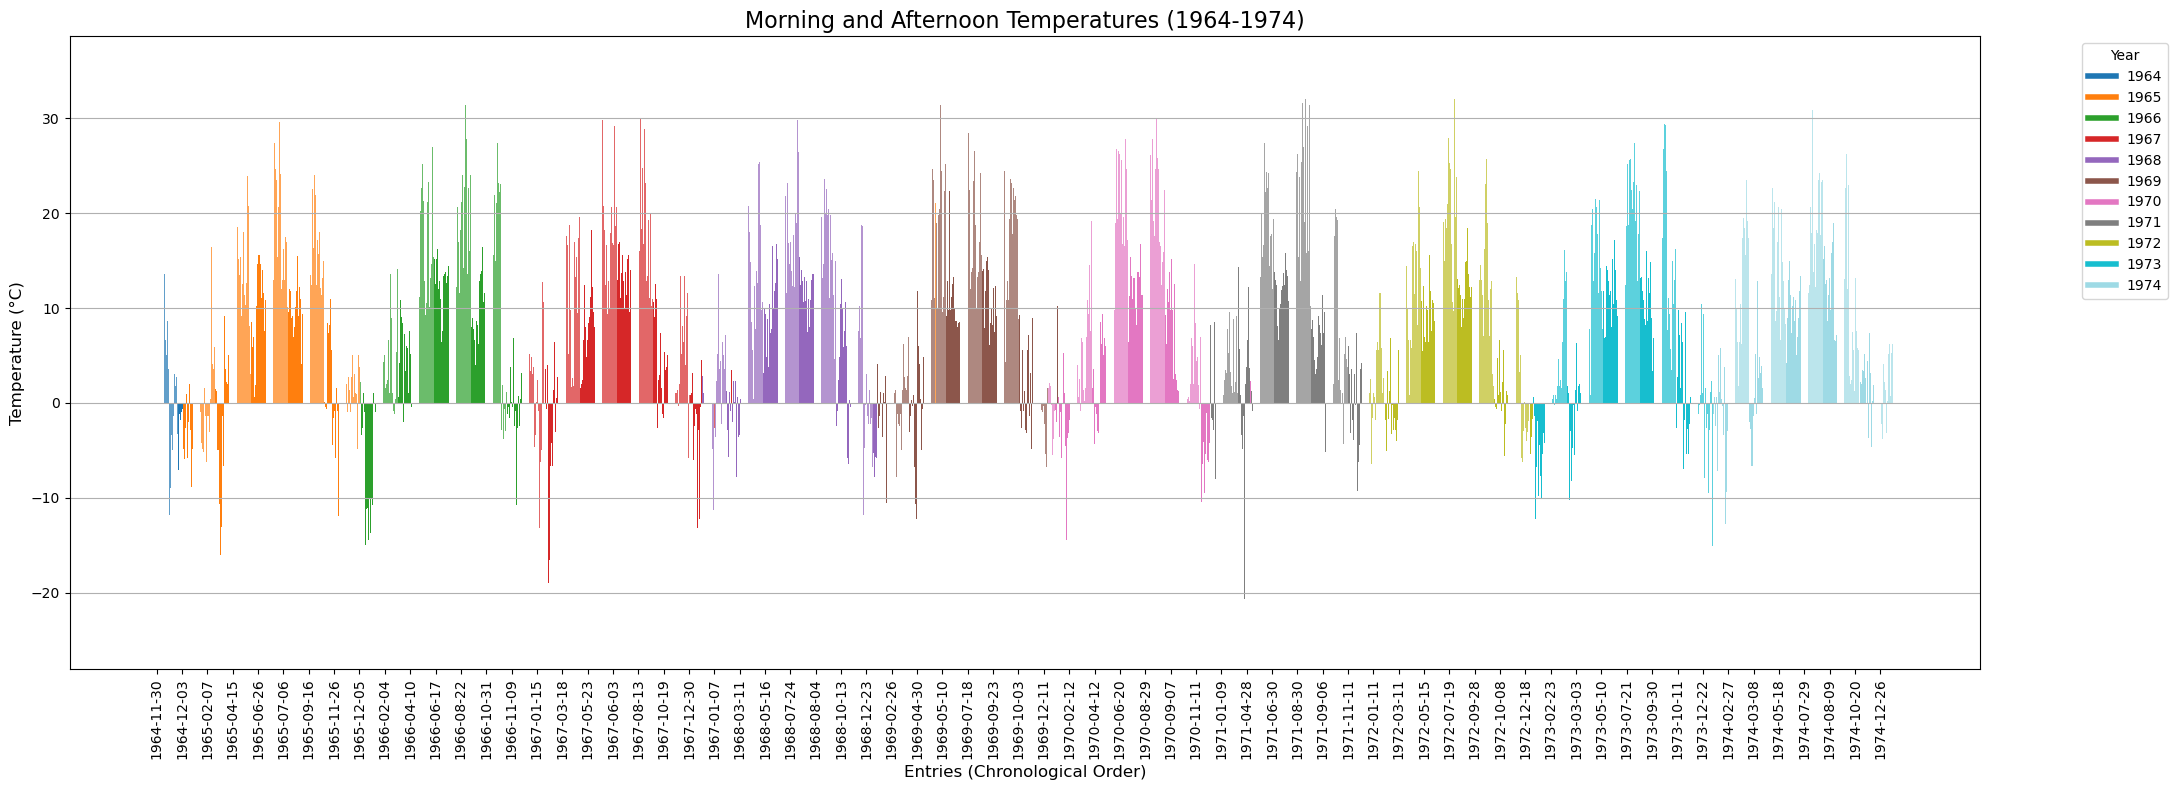

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

final_output_file = "final_visualization_data/filtered_weather_data.json"
data = pd.read_json(final_output_file)

data['date'] = pd.to_datetime(data['date'], errors='coerce')  # Coerce invalid dates to NaT
data = data.dropna(subset=['date'])

data['year'] = data['date'].dt.year

filtered_data = data[(data['year'] >= 1964) & (data['year'] <= 1974)].reset_index(drop=True)

colors = plt.cm.get_cmap('tab20', len(filtered_data['year'].unique()))  # Assign a unique color for each year
filtered_data['color'] = filtered_data['year'].map(
    lambda year: colors(filtered_data['year'].unique().tolist().index(year))
)

x = np.arange(len(filtered_data))  # One bar per entry
width = 0.4  # Width of the bars

plt.figure(figsize=(20, 8))
plt.bar(x - width/2, filtered_data['temperature'].apply(lambda t: t['morning']), 
        width, color=filtered_data['color'], label='Morning Temp')
plt.bar(x + width/2, filtered_data['temperature'].apply(lambda t: t['afternoon']), 
        width, color=filtered_data['color'], label='Afternoon Temp', alpha=0.7)

plt.title('Morning and Afternoon Temperatures (1964-1974)', fontsize=16)
plt.xlabel('Entries (Chronological Order)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(ticks=x[::50], labels=filtered_data['date'].dt.strftime('%Y-%m-%d')[::50], rotation=90)
plt.legend(['Morning Temp', 'Afternoon Temp'])
plt.grid(axis='y')
plt.tight_layout()

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors(i), lw=4, label=str(year))
    for i, year in enumerate(filtered_data['year'].unique())
]
plt.legend(handles=legend_elements, title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()